In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [3]:
from tqdm.notebook import tqdm

torch.Size([1020, 100])


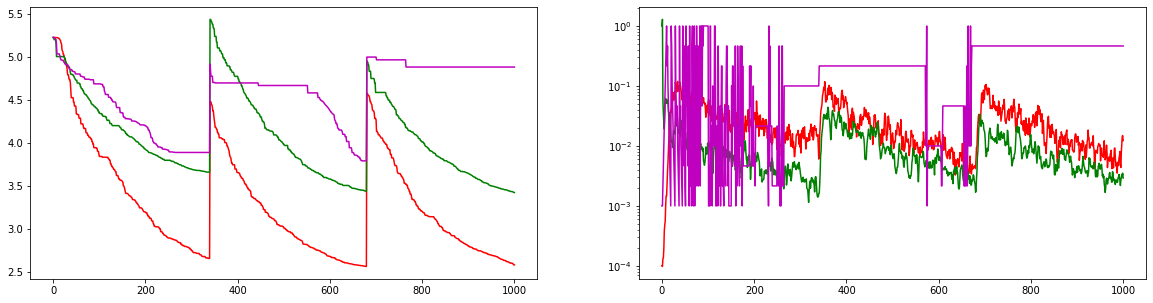

In [152]:
do_seed(13)
shift = 1*torch.randn(100)
# shift = 5
def shift_ackley(x):
    return ackley(x-shift)
i = 0
def changing_fn(x):
    global i
    i=i+1
    if i<200:
        return sphere(x)
    else:
#         return 10*ackley(x-shift)
        return 1*sphere(x-shift)

shift = torch.randn(3, 1, 100)
shift = shift.repeat(1, 340, 1).reshape(-1, 100)
shift = 5*shift/shift.norm(dim=-1, keepdim=True)
print(shift.shape)
def changing_fn(x):
    global i
    i=i+1
#     if i>998:
#         print(i)
    return ackley(x-shift[i-1])
    

# pop = torch.zeros(101, 100)
pop = torch.randn(101, 100)*1
i=0
# pops, fits, mrs, _ = optim.run_evolution_ours(pop, changing_fn, 1000, 10, mr=None)
i=0
pops, fits_s, mrs_s, _ = optim.run_evolution_ours(pop, changing_fn, 1000, 10, mr=1e-4)
i=0
pops, fits_ns, mrs_ns = optim.run_evolution_ns(pop, changing_fn, 1000)
i=0
pops, fits_ucb, mrs_ucb = optim.run_evolution_ucb(pop, changing_fn, 1000, torch.logspace(-3, 0, 10))
plt.figure(figsize=(20, 5))
plt.subplot(121)
# plt.plot(fits.min(dim=-1).values)
plt.plot(fits_s.min(dim=-1).values, c='r')
plt.plot(fits_ns.min(dim=-1).values, c='g')
plt.plot(fits_ucb.min(dim=-1).values, c='m')
plt.subplot(122)
# plt.plot(mrs[:, :, 0].log().mean(dim=-1).exp())
plt.plot(mrs_s[:, :, 0].log().mean(dim=-1).exp(), c='r')
plt.plot(mrs_ns[:, :, 0].log().mean(dim=-1).exp(), c='g')
plt.plot(mrs_ucb, c='m')
plt.yscale('log')


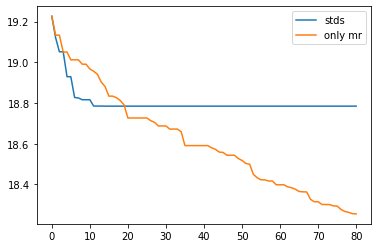

In [7]:
def run_evolution_dir(pop, optim_fn, n_gen, n_mutpop=10, mr=None, mr_mut=2., 
                       k=.5, k_elite=None,
                       tqdm=lambda x: x):
#     if mr is None:
#         mutpop = torch.logspace(-3, 3, n_mutpop, device=pop.device)[:, None]
#     else:
#         mutpop = torch.linspace(mr, mr, n_mutpop, device=pop.device)[:, None]
        
    mr_means = torch.zeros(n_mutpop, pop.shape[-1], device=pop.device)
    mr_stds = torch.logspace(-3, 3, n_mutpop)
    mr_stds = mr_stds[:, None].repeat(1, pop.shape[-1])
    
    data = []
    mrpop2mr = np.arange(len(pop)-1)//int(len(pop)/len(mr_means))
    fit = optim_fn(pop)
    for i in tqdm(range(n_gen)):
#         print('------------------------------')
#         print(f'Generation {i}')
        bpop = pop
        bfit = fit
        
        idxs_elite, idxs_rest, idxs_cat = optim.calc_npop_idxs(fit, k=k, k_elite=k_elite)
#         pop = optim.calc_npop_gaussian(pop, mutpop[mrpop2mr], idxs_elite, idxs_rest, idxs_cat)
        m = mr_means[mrpop2mr]
        s = mr_stds[mrpop2mr]
        pop = optim.calc_npop_gaussian_mean_std(pop, m, s,
                                                idxs_elite, idxs_rest, idxs_cat)
        fit = optim_fn(pop)
        fit_mrs = (fit[1:]-bfit[idxs_rest]).reshape(len(mr_means), -1)
        data.append((bpop, bfit, mr_means, mr_stds, fit_mrs))
        fit_mrs_min = fit_mrs.min(dim=-1).values
        
        
        mr_stds_mean = mr_stds.log().mean(dim=-1).exp()
        mr_rank = mr_stds_mean.argsort()
#         print(fit_mrs.shape)
#         if i%10==0:
#             plt.plot(fit_mrs.min(dim=-1).values[mr_rank], mr_stds_mean[mr_rank], c='r', linewidth=1)
#             for i in range(10):
#                 plt.scatter(fit_mrs[:, i], mr_stds_mean, c='b', s=5)
#             plt.yscale('log')
#             plt.show()
#         for i in range(n_mutpop):
#             print(f'Average STD: {mr_stds.log().mean(dim=-1).exp()[i].item():.2e}')
#             for fit_mr_i in fit_mrs[i]:
#                 print(f'\t {fit_mr_i}')
        
        mr_idxs_sel = optim.calc_npop_idxs(fit_mrs_min, k=.5)
        mr_stds = optim.calc_npop_log_uniform(mr_stds, mr_mut, *mr_idxs_sel)
#         mr_means = optim.calc_npop_gaussian(mr_means, 1e-2, *mr_idxs_sel)
    data.append((pop, fit, mr_means, mr_stds, fit_mrs))
        
    # pops, fits, mrs, fitmrs
    return [torch.stack([d[i] for d in data]) for i in range(len(data[0]))]


do_seed(5)
n_gen = 80
# pop = torch.randn(101, 100)*10
pop = 10*torch.randn(1, 100).repeat(101, 1)
optim_fn = ackley
pops_dir, fits_dir, mr_means, mr_stds, _ = run_evolution_dir(pop, optim_fn, n_gen)
plt.plot(fits_dir.min(dim=-1).values, label='stds')
pops, fits, mrs, _ = optim.run_evolution_ours(pop, optim_fn, n_gen, )
plt.plot(fits.min(dim=-1).values, label='only mr')
plt.legend()

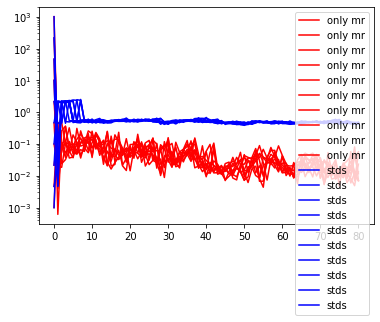

In [8]:
plt.plot(mrs[:, :, 0],c='r', label='only mr');
plt.plot(mr_stds.log().mean(dim=-1).exp(), c='b', label='stds');
plt.yscale('log')
plt.legend()

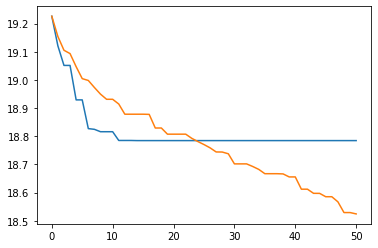

In [428]:
do_seed(5)
n_gen = 50
# pop = torch.randn(101, 100)*10
pop = 10*torch.randn(1, 100).repeat(101, 1)
optim_fn = ackley
pops_dir, fits_dir, mr_means, mr_stds, _ = run_evolution_dir(pop, optim_fn, n_gen)
plt.plot(fits_dir.min(dim=-1).values)
pops, fits, mrs, _ = optim.run_evolution_ours(pop, optim_fn, n_gen, )
plt.plot(fits.min(dim=-1).values)


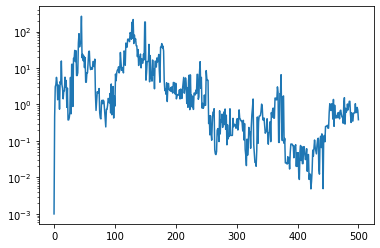

In [376]:
plt.plot(mr_stds[:, 0, 0])
plt.yscale('log')

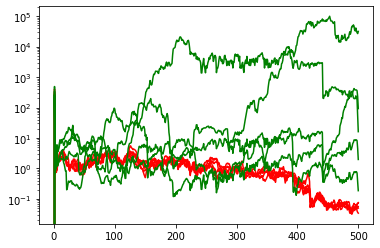

In [362]:
# pops.mean(dim=-2).shape
plt.plot(pops.std(dim=-2)[:, ::20], c='r')
plt.plot(pops_dir.std(dim=-2)[:, ::20], c='g')
plt.yscale('log')

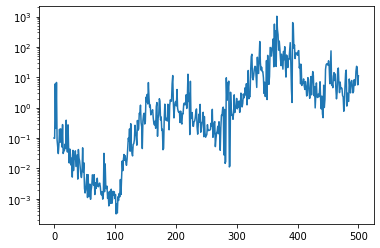

In [340]:
plt.plot(mr_stds[:, 3, 0])
plt.yscale('log')

In [292]:
pops.shape, fits.shape, mr_means.shape, mr_stds.shape

(torch.Size([501, 101, 100]),
 torch.Size([501, 101]),
 torch.Size([501, 10, 100]),
 torch.Size([501, 10, 100]))

In [293]:
mr_means.max()

tensor(0.5505)